In [56]:
import os
import pandas as pd 
import seaborn as sns
import numpy as np
import sklearn
import datetime as dt
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import *
from IPython.display import display, Markdown, Latex

In [57]:
# Tell Jupyter to show all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [87]:
def main():
    # Import Data
    df = importData()
    
    # Manipulate Data
    df = manipData(df)
    
    # Plot Data
    plotData(df)

    # Create expression for the regression (response, and predictors)
    regFormula = prepForModel('BASKET_TOTAL',['D00001','D00002','D00003','D00004','D00005',
                                              'D00006','D00008','D00009','QUANTITY', 'SHOP_WEEKDAY'])
    
    # Create a Training and Validation data splits. Specify training proportion
    dfTrain, dfValidation = splitData(df, percent = 0.8)

    # Model on Training Data
    buildModel(regFormula,dfTrain) 
    Regression_training = buildModel(regFormula,dfTrain)
    print(Regression_training.summary())
    
    # Show Actual by Predicted plot of Training Data
    sns.regplot(x=Regression_training.fittedvalues, y=dfTrain['BASKET_TOTAL'], fit_reg=True)
    plt.title('Actual by Predicted Plot - Training Data')
    plt.xlabel('Predicted_Basket_Total')
    plt.ylabel('Actual_Basket')
    plt.xlim((0,600))
    plt.ylim((0,600))
    plt.show()
    
    # Show Residual by Predicted plot of Training Data
    sns.regplot(x=Regression_training.fittedvalues, y=Regression_training.resid, fit_reg=False)
    plt.title('Residual Plot - Training Data')
    plt.xlabel('Predicted_Basket_Total')
    plt.ylabel('Basket_Total_Residual')
    plt.show()
      
    # Model on Validation Data
    buildModel(regFormula,dfValidation)
    Regression_validation = buildModel(regFormula,dfValidation)
    print(Regression_validation.summary())
    
    # Show Actual by Predicted plot of Validation Data
    sns.regplot(x=Regression_validation.fittedvalues, y=dfValidation['BASKET_TOTAL'], fit_reg=True)
    plt.title('Actual by Predicted Plot - Validation Data')
    plt.xlabel('Predicted_Basket_Total')
    plt.ylabel('Actual_Basket_Total')
    plt.xlim((0,600))
    plt.ylim((0,600))
    plt.show()
    
    # Show Residual by Predicted plot of Validation Data
    sns.regplot(x=Regression_validation.fittedvalues, y=Regression_validation.resid, fit_reg=False)
    plt.title('Residual Plot - Validation Data')
    plt.xlabel('Predicted_Basket_Total')
    plt.ylabel('Actual_Basket_Total_Residual')
    plt.show()
    
    # Output training dataset predictions
    outputPredictionFile('Basket_Predictions.csv',Regression_training)

def importData():
    while True:
        try:
            myfile = str(input('Enter string of filename to import. File must be in the working directory. CSV format only. (Hint - the filename for this analysis is 2006_07.csv): '))
            df = pd.read_csv(myfile)
            print('File has been imported as pandas dataframe')
            break
        except FileNotFoundError as excl:
            print(excl)    
    return(df)

def manipData(df):
    # Make SHOP_DATE string into datetime
    df['SHOP_DATE'] = pd.to_datetime(df['SHOP_DATE'],format = ('%Y%m%d'))

    # Create Extended Spend Column which is quantity of a given item in a basket times its price
    df['EXT_SPEND'] = ''
    df.loc[:,'EXT_SPEND'] = df['SPEND'] * df['QUANTITY']

    # Get total for each basket and add as a new column 'BASKET_TOTAL'
    basketTotals = pd.DataFrame(df.groupby(['BASKET_ID'])['EXT_SPEND'].sum())
    basketTotals['BASKET_ID'] = basketTotals.index

    # Get the total numbr of products in the basket
    qtyTotals = pd.DataFrame(df.groupby(['BASKET_ID'])['QUANTITY'].sum())
    qtyTotals['BASKET_ID'] = qtyTotals.index

    # Aggregate dataframe by Basket ID and by Prod_Code_40
    df_grouped = pd.DataFrame(df.groupby(['BASKET_ID','PROD_CODE_40'])['QUANTITY'].sum())

    # Get list of multiindex in df_grouped so we can split it 
    myindices = list(df_grouped.index)

    # Split the multiIndex into two series 
    mydfgroupedIdx = [item[0] for item in myindices]
    myPROD_CODE_40 = [item[1] for item in myindices]

    # Add series to dataframe as columns
    df_grouped['BASKET_ID'] = mydfgroupedIdx
    df_grouped['PROD_CODE_40'] = myPROD_CODE_40

    # Set BASKET_ID column as the dataframe's index
    df_grouped.index = mydfgroupedIdx

    # Pivot Unique Values of PROD_CODE_40 into columns to get a row-wise count of each PRODUCT_CODE
    df_new = df_grouped.pivot(columns='PROD_CODE_40', values='QUANTITY')
    df_new = df_new.fillna(0)
    df_new['BASKET_ID'] = df_new.index

    # Add BASKET_TOTAL to the new dataframe
    df_all = pd.merge(df_new,basketTotals, how = 'inner', on = ['BASKET_ID','BASKET_ID'])

    # Add QUANTITY_TOTAL to the new dataframe
    df_all = pd.merge(df_all,qtyTotals, how = 'inner', on = ['BASKET_ID','BASKET_ID'])

    # Rename Columns
    df_all = df_all.rename(index = str, columns = {'EXT_SPEND':'BASKET_TOTAL', 'QUANTITY':'QUANTITY'})

    # Get Unique Values for Other Predictor Co
    df_unique_a = pd.DataFrame(df.groupby(['BASKET_ID'])['SHOP_WEEKDAY'].unique())
    dfa = df_unique_a['SHOP_WEEKDAY'].str[0]
    dfa = pd.DataFrame(dfa)
    dfa['BASKET_ID'] = dfa.index

    # Finalize DataFrame for Model
    df_all2 = pd.merge(df_all, dfa, how = 'inner', on = ['BASKET_ID','BASKET_ID'])
    df_all3 = df_all2.dropna()
    df_all3 = df_all3[df_all3['BASKET_TOTAL'] < 2000] # Remove an outlier

    return(df_all3)

def plotData(df):
    df['QUANTITY'].plot(kind = 'hist')
    plt.title('Distribution of QUANTITY')
    plt.show()

    np.log(df['QUANTITY']).plot(kind = 'hist')
    plt.title('Distribution of QUANTITY')
    plt.show()

    df['BASKET_TOTAL'].plot(kind = 'hist', bins= 100)
    plt.xlim((0,400))
    plt.title('Distribution of BASKET_TOTAL')
    plt.show()

    np.log(df['BASKET_TOTAL'] + 1).plot(kind = 'hist')
    plt.title('Distribution of BASKET_TOTAL')
    plt.show()

    df['LOG_BASKET_TOTAL'] = ''
    df.loc[:,['LOG_BASKET_TOTAL']] = np.log(df['BASKET_TOTAL'] + 1)
    plt.show()

    sns.boxplot(x="SHOP_WEEKDAY", y="LOG_BASKET_TOTAL", data=df);
    plt.show()

def splitData(df,percent):
    train = df.sample(frac=percent, random_state=99)
    validation = df.loc[~df.index.isin(train.index), :]
    return(train,validation)

def prepForModel(yResponse,xPredictors):
    formula = ''
    for i in range(0,len(xPredictors)+1):
        if i == 1:
            formula = xPredictors[i]
        else:
            formula = formula + ' + ' + xPredictors[i-1]
    formula = yResponse + ' ~ ' + ' ' + formula
    return(formula)

def buildModel(inputFormula,df):
    mod = smf.ols(formula= inputFormula, data=df)
    reg = mod.fit()
    return(reg)

def outputPredictionFile(outfilename,predSeries):
    df = pd.DataFrame(predSeries.fittedvalues)
    df['RowNumber'] = df.index
    df.columns = ['PredictedBasketTotal','RowNumber']
    df = df.sort_values(by=['RowNumber'])
    df.to_csv(outfilename, index = False)
    print('File ' + outfilename + ' was written to working directory')


Enter string of filename to import. File must be in the working directory. CSV format only. (Hint - the filename for this analysis is 2006_07.csv): 2006_07.csv
File has been imported as pandas dataframe


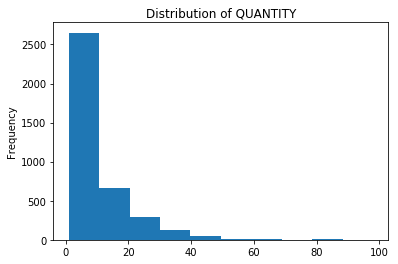

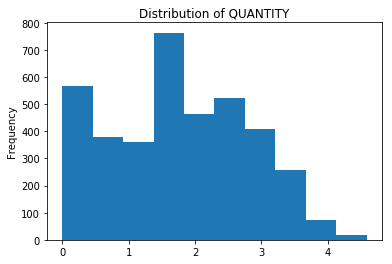

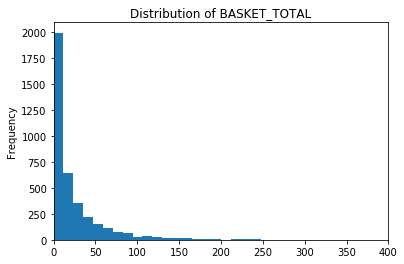

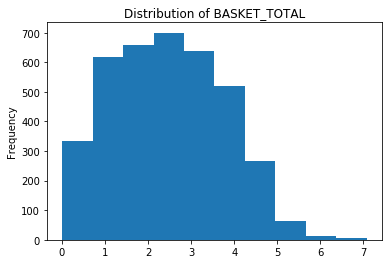

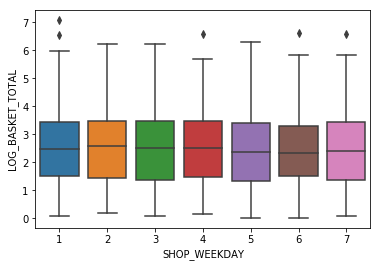

                            OLS Regression Results                            
Dep. Variable:           BASKET_TOTAL   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     454.5
Date:                Sun, 22 Apr 2018   Prob (F-statistic):               0.00
Time:                        22:01:18   Log-Likelihood:                -15052.
No. Observations:                3050   AIC:                         3.012e+04
Df Residuals:                    3040   BIC:                         3.018e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.9374      1.491     -3.311   

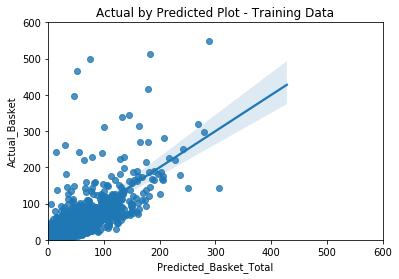

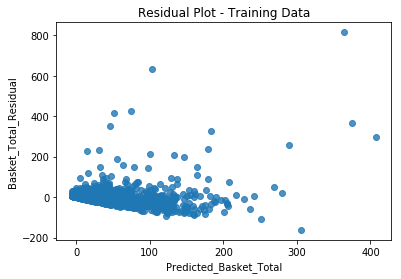

                            OLS Regression Results                            
Dep. Variable:           BASKET_TOTAL   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     114.6
Date:                Sun, 22 Apr 2018   Prob (F-statistic):          1.18e-134
Time:                        22:01:19   Log-Likelihood:                -3654.2
No. Observations:                 763   AIC:                             7328.
Df Residuals:                     753   BIC:                             7375.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.0733      2.645     -1.540   

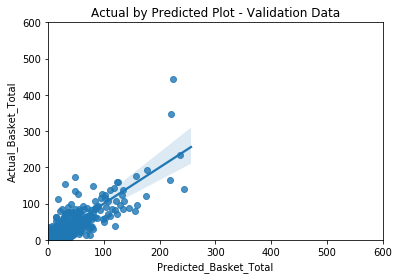

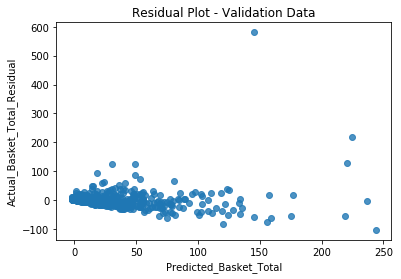

    PredictedBasketTotal  RowNumber
1               3.350855          1
2              -2.998575          2
3              19.456407          3
4              -3.940337          4
5               1.145533          5
6              38.506200          6
7               0.089785          7
8               9.715980          8
9              67.323546          9
10             -2.054715         10
File Basket_Predictions.csv was written to working directory


In [88]:
main()